# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from typing import Sequence, Union
from functools import partial

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 12345

# Dataset: 4 folded diffused circles

In [2]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
np.random.seed(seed=7)

n_samples = 100
radii = [2.0, 5.0]
factors = [0.5, 0.7]

X = []
y = []

for i, d in enumerate(radii):
    _X, _y = make_circles(n_samples=int(n_samples*d), noise=0.1, random_state=81, factor=factors[i])
    for i, _ in enumerate(_y):
        X.append(_X[i,:]*d)
        y.append(_y[i])
    
X = np.array(X)
y = np.array(y)
y = 2*y-1 # rescale to [-1,1]

# plt.figure(figsize=(5,5))
# plt.scatter(X[:, 0], X[:, 1], s=50, c=y, marker='o', cmap=plt.cm.Paired)
# plt.show()

xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)
# X = MaxAbsScaler().fit_transform(X)

# shuffle dataset elements
def unison_shuffled(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, y = unison_shuffled(X, y)
print(X.shape)

(700, 2)


Training target statistics: Counter({-1: 10, 1: 10})
Testing target statistics: Counter({-1: 10, 1: 10})


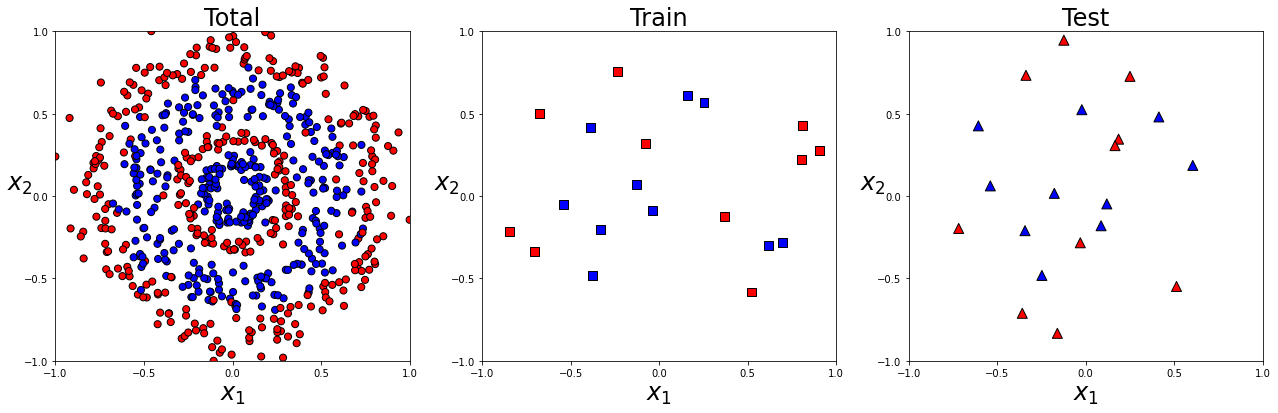

In [3]:
from sklearn.model_selection import train_test_split

train_size = 20
test_size = 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=24)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# QKT SVM

## Quantum backend

In [4]:
#------------------------
# Choose quantum backend
#------------------------
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = seed
backend = QuantumInstance(
    AerSimulator(
        method='statevector',
        max_parallel_threads=8,
    ),
    seed_simulator=seed, seed_transpiler=seed,
)

## Optimizer

In [5]:
from qksvm.QuantumKernelTraining import QKTCallback
callback = QKTCallback()

np.random.seed(seed)
algorithm_globals.random_seed = seed

opt = 'SPSA'

if opt=='SPSA':
    from qiskit.algorithms.optimizers import SPSA
    from qksvm.QuantumKernelTraining import TerminationChecker
    optimizer = SPSA(
        maxiter=1000,
        learning_rate=None,
        perturbation=None,
        callback=callback.callback,
        termination_checker=TerminationChecker(0.0001, N=5),
    )
    # print(optimizer.is_bounds_required)
elif opt=='CG':
    from qiskit.algorithms.optimizers import CG
    optimizer = CG(
        maxiter=100,
        tol=1e-3,
    )
elif opt=='L_BFGS_B':
    from qiskit.algorithms.optimizers import L_BFGS_B
    optimizer = L_BFGS_B(
        maxiter=100,
        ftol=1e-3,
    )
elif opt=='NM':
    from qiskit.algorithms.optimizers import NELDER_MEAD
    optimizer = NELDER_MEAD(
        maxiter=1000,
        maxfev=10000,
        disp=False,
        tol=0.001,
        adaptive=True
    )
elif opt=='BOB':
    # BOBYQA requires bounds that are not supported in the official Qiskit version
    # For testing I've cloned and modified QuantumKernelTrainer in QuantumKernelTraining.py
    from qiskit.algorithms.optimizers import BOBYQA
    optimizer = BOBYQA(
        maxiter=1000
    )
    print(optimizer.is_bounds_required)
    bounds = np.zeros((len(fm.train_params), 2))
    bounds[:,1] = 2*np.pi
    optimizer.set_options(bounds=bounds)
 

## Quantum Feature Map

In [6]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['RX', 'cz'], entanglement='linear',
    repeat=True,
    scale=True,
)
for i in range(fm.num_qubits):
    fm.rx(fm.encod_params[i%fm.num_features], i)

print(fm.draw(plot_barriers=False, fold=120))

     ┌───────────────┐     ┌───────────────┐     ┌───────────────┐
q_0: ┤ Rx(x[0]*θ[0]) ├──■──┤ Rx(x[0]*θ[0]) ├──■──┤ Rx(x[0]*θ[0]) ├
     ├───────────────┤  │  ├───────────────┤  │  ├───────────────┤
q_1: ┤ Rx(x[1]*θ[0]) ├──■──┤ Rx(x[1]*θ[0]) ├──■──┤ Rx(x[1]*θ[0]) ├
     └───────────────┘     └───────────────┘     └───────────────┘


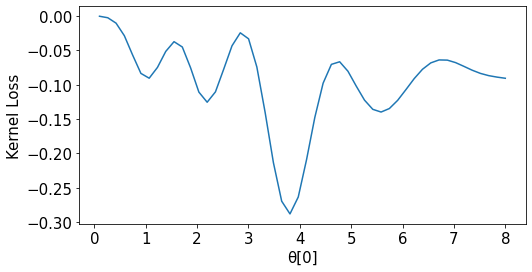

In [7]:
from qksvm.LossFunctions import KTALoss

loss = KTALoss(rescale=True)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

loss.plot(fm, X_train, y_train, init_params, backend)

KTA Loss optimal value:  -0.2883439984950686
Optimal parameters: [3.79622358]


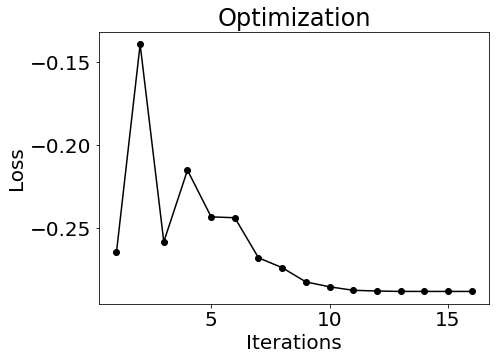

In [8]:
np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 3.0

from qksvm.QuantumKernelTraining import QuantumKernelOptimizer
algorithm_globals.random_seed = seed

callback.clear_callback_data()

qkt_results = QuantumKernelOptimizer(
    fm, 
    X_train, y_train,
    init_params=init_params,
    backend=backend, 
    optimizer=optimizer,
    loss=loss,
    seed=seed,
)

print('KTA Loss optimal value: ', qkt_results.optimal_value)
print('Optimal parameters:', qkt_results.optimal_point)

callback.plot()

In [9]:
qsvc = SVC(kernel=qkt_results.quantum_kernel.evaluate, random_state=seed, class_weight=None)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')


Train scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  0.99
                 MCC:  0.80

Test scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.85
                 MCC:  0.61


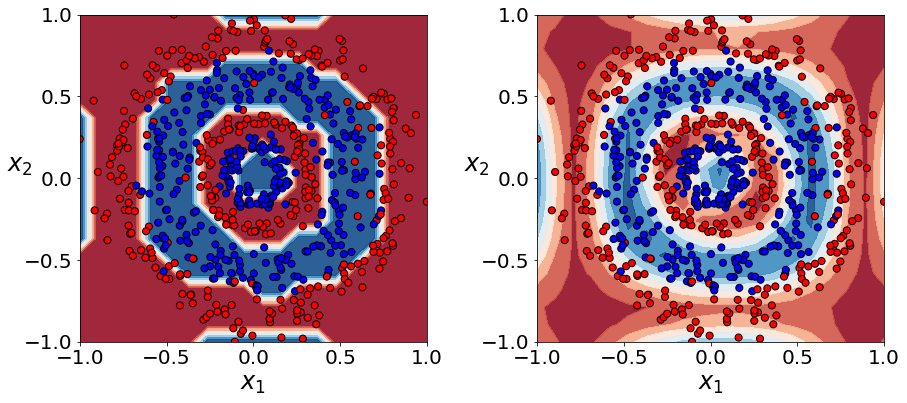

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()